### Загрузка претрейн файлов модели

In [1]:
!git clone https://github.com/thuml/Time-Series-Library.git
!pip install patool sktime reformer-pytorch
!wget -O TimesNet.pth "https://www.dropbox.com/scl/fi/3fy1s3c3fj8dk10tn12j8/TimesNet.pth?rlkey=ojvyt9cqx0d016gf1up3b48a8&st=znf8wzdl&dl=0" 

Cloning into 'Time-Series-Library'...
remote: Enumerating objects: 1846, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 1846 (delta 4), reused 8 (delta 3), pack-reused 1830 (from 1)
Receiving objects: 100% (1846/1846), 78.20 MiB | 42.12 MiB/s, done.
Resolving deltas: 100% (1269/1269), done.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 40.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.2 MB/s eta 0:00:00
  Created wheel for axial-positional-embedding: filename=axial_positional_embedding-0.2.1-py3-none-any.whl size=2889 sha256=04bb79a5bd5bebaf819e6a6e620e5c47baca3a81f532e20d79d0916b2fe99383
  Stored in directory: /root/.cache/pip/wheels/b1/cb/39/7ce7ff2d2fd37cfe1fe7b3a3c43c

### Загрузка датасета на котором тестируемся (и обучались)

In [2]:
! pip install gdown

In [3]:
import gdown
import os
file_id = "1ArO13Ix-F4S63M4P8T1gC7diFWOMIdZ5"
url = f'https://drive.google.com/uc?id={file_id}'
output_path = "heartbit.zip"
gdown.download(url, output_path)

Downloading...
From (original): https://drive.google.com/uc?id=1ArO13Ix-F4S63M4P8T1gC7diFWOMIdZ5
From (redirected): https://drive.google.com/uc?id=1ArO13Ix-F4S63M4P8T1gC7diFWOMIdZ5&confirm=t&uuid=a42bef7c-fa48-4b4a-bdf8-267dd7d5e97f
To: /kaggle/working/heartbit.zip
100%|██████████| 27.4M/27.4M [00:00<00:00, 95.2MB/s]


'heartbit.zip'

In [4]:
! unzip heartbit -d dataset

Archive:  heartbit.zip
   creating: dataset/Heartbeat/
  inflating: dataset/Heartbeat/Heartbeat_TRAIN.ts  
  inflating: dataset/Heartbeat/Heartbeat_TEST.ts  


In [5]:
import os
import sys
sys.path.append('Time-Series-Library')

### Загрузка модели

In [6]:
from models.TimesNet import Model as TimesNet
import argparse
import os
import torch
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
from exp.exp_imputation import Exp_Imputation
from exp.exp_short_term_forecasting import Exp_Short_Term_Forecast
from exp.exp_anomaly_detection import Exp_Anomaly_Detection
from exp.exp_classification import Exp_Classification
from data_provider.data_factory import data_provider
from utils.print_args import print_args
import random
import numpy as np
from typing import NamedTuple
from models.Autoformer import Model as Autoformer
from models.Nonstationary_Transformer import Model as NonStationary
from utils.metrics import metric as get_metrics_internal

class Config:
    def __init__(self,**kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)


def init_timesnet(load_weights=True):
    args = Config(**{
        "task_name": "classification",
        "is_training": 0,
        "root_path": "./dataset/Heartbeat" ,
        "model_id": "Heartbeat" ,
        "model": "TimesNet",
        "data": "UEA",
        "checkpoints": "checkpoints",
        "features": "M",
        "p_hidden_dims": [128, 128],
        "p_hidden_layers": 2,
        "seq_len": 405,
        "label_len": 48,
        "freq": "h",
        "top_k": 1,
        "pred_len": 0,
        "e_layers": 3,
        "num_class": 2,
        "embed": "timeF",
        "d_layers": 1,
        "factor": 1,
        "enc_in": 61,
        "dec_in": 7 ,
        "c_out": 7,
        "d_ff": 32,
        "activation": "gelu",
        "dropout": 0.1,
        "num_kernels": 6,
        "moving_avg": 25,
        "d_model": 16
    })
    model = TimesNet(args)
    if load_weights:
        model.load_state_dict(torch.load('./TimesNet.pth'))
    return model

In [7]:
model = init_timesnet()

In [8]:
model

Model(
  (model): ModuleList(
    (0-2): 3 x TimesBlock(
      (conv): Sequential(
        (0): Inception_Block_V1(
          (kernels): ModuleList(
            (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
            (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (3): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
            (4): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
            (5): Conv2d(16, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
          )
        )
        (1): GELU(approximate='none')
        (2): Inception_Block_V1(
          (kernels): ModuleList(
            (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
            (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        

In [9]:
for name, _ in model.named_parameters():
    print(name)

model.0.conv.0.kernels.0.weight
model.0.conv.0.kernels.0.bias
model.0.conv.0.kernels.1.weight
model.0.conv.0.kernels.1.bias
model.0.conv.0.kernels.2.weight
model.0.conv.0.kernels.2.bias
model.0.conv.0.kernels.3.weight
model.0.conv.0.kernels.3.bias
model.0.conv.0.kernels.4.weight
model.0.conv.0.kernels.4.bias
model.0.conv.0.kernels.5.weight
model.0.conv.0.kernels.5.bias
model.0.conv.2.kernels.0.weight
model.0.conv.2.kernels.0.bias
model.0.conv.2.kernels.1.weight
model.0.conv.2.kernels.1.bias
model.0.conv.2.kernels.2.weight
model.0.conv.2.kernels.2.bias
model.0.conv.2.kernels.3.weight
model.0.conv.2.kernels.3.bias
model.0.conv.2.kernels.4.weight
model.0.conv.2.kernels.4.bias
model.0.conv.2.kernels.5.weight
model.0.conv.2.kernels.5.bias
model.1.conv.0.kernels.0.weight
model.1.conv.0.kernels.0.bias
model.1.conv.0.kernels.1.weight
model.1.conv.0.kernels.1.bias
model.1.conv.0.kernels.2.weight
model.1.conv.0.kernels.2.bias
model.1.conv.0.kernels.3.weight
model.1.conv.0.kernels.3.bias
model.1.

### Квантильная квантизация

In [10]:
import numpy as np

def quantanize_array(weights, parts=256):
    data = weights.detach().numpy()
    if data.shape[0] < parts:
        return data
        
    argsort_data = np.argsort(data)
    sort_data = data[argsort_data]
    step = data.shape[0] // parts
    for i in range(0, sort_data.shape[0], step):
        data[argsort_data[i: i + step]] = np.array([sort_data[i: i + step].mean()] * sort_data[i: i + step].shape[0])
        
    return data

In [11]:
@torch.no_grad()
def quantanize_TimesNet(model, parts=16):
    for name, params in model.named_parameters():
        if ('conv' in name and 'weight' in name) or 'tokenConv' in name:
            for i in range(params.shape[0]):
                shape_src = params[i].shape
                dtype = params.dtype
                device = params.device
                params[i] = torch.tensor(quantanize_array(params[i].reshape(-1).cpu(), parts), dtype=dtype, device=device).reshape(shape_src)
        else:
            shape_src = params.shape
            dtype = params.dtype
            device = params.device
            params.copy_(torch.tensor(quantanize_array(params.reshape(-1).cpu(), parts), dtype=dtype, device=device).reshape(shape_src))

In [12]:
# quantanize_TimesNet(model, 16) # int 4
# quantanize_TimesNet(model, 256) # int 8

### Реализация логики QLora

[Статья с логикой для свёрточных слоёв](https://medium.com/@adimodi96/implementing-low-rank-adaptation-lora-for-convolutional-layers-04decdf2e3b3)

In [99]:
from torch import nn
from torch.nn import functional as F
import math

class LoRALinear(nn.Module):
    
    def __init__(self, original_layer: nn.Linear, r: int, alpha: float = 1.0) -> None:
        super().__init__()

        assert isinstance(original_layer, nn.Linear) , (
            'Wrong type! The base module should be of type `torch.nn.Linear`.'
        )
        
        self.original_layer = original_layer
        self._adapters_enabled = True
        self.disable_base_gradients()
        self.B = nn.Parameter(torch.zeros(
            size=(self.original_layer.weight.size(0), r), 
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device))
        self.A = nn.Parameter(torch.empty(
            size=(r, self.original_layer.weight.size(1)), 
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device
        ))
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        self.scaling = alpha / r
        self.register_buffer(
            'alpha',
            torch.tensor(
                data=(alpha,),
                dtype=self.original_layer.weight.dtype,
                device=self.original_layer.weight.device
            )
        )

        self.register_buffer(
            'rank',
            torch.tensor(
                data=(r,),
                dtype=torch.int,
                device=self.original_layer.weight.device
            )
        )

    def disable_base_gradients(self) -> None:
        self.original_layer.weight.requires_grad_(False)
        if self.original_layer.bias is not None:
            self.original_layer.bias.requires_grad_(False)

    def enable_base_gradients(self) -> None:
        self.original_layer.weight.requires_grad_(True)
        if self.original_layer.bias is not None:
            self.original_layer.bias.requires_grad_(True)

    def enable_adapters(self) -> None:
        self._adapters_enabled = True

    def disable_adapters(self) -> None:
        self._adapters_enabled = False

    @torch.no_grad()
    def update_weights(self) -> None:
        self.original_layer.weight = self.original_layer.weight + self.B @ self.A * self.scaling

    @torch.no_grad()
    def reset_adapters(self) -> None:
        self.B.data = torch.zeros(
            size=(self.original_layer.weight.size(0), self.rank.item()), 
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device)
        self.A.data = torch.empty(
            size=(self.rank.item(), self.original_layer.weight.size(1)), 
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device) * 0.01
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))

    def eval(self) -> None:
        super().eval()
        self.update_weights()

    def train(self, mode: bool = True) -> None:
        super().train(mode)  
        if mode:
            self.reset_adapters()
    
    def forward(self, x: torch.Tensor, padding_mask: torch.Tensor = None) -> torch.Tensor:
        if self._adapters_enabled and model.training:
            output =  self.original_layer(x) + ((self.B @ self.A * self.scaling) @ x.T).T
        else:
            output = self.original_layer(x)

        # if padding_mask is not None:
            # output = output * padding_mask.unsqueeze(-1)

        return output
        
            
class LoRAConv2D(nn.Module):
    
    def __init__(self, original_layer: nn.Conv2d, r: int, rank_for: str = 'kernel', alpha: float = 1.0) -> None:
        super().__init__()
        
        assert isinstance(original_layer, nn.Conv2d), (
            'Wrong type! The base module should be of type `torch.nn.Conv2d`.'
        )

        out_channels, in_channels, kH, kW = original_layer.weight.size()
        self.rank_for = rank_for
        self.original_layer = original_layer
        self.disable_base_gradients()
        self.scaling = alpha / r
        self._adapters_enabled = True

        if rank_for == 'kernel':
            self.b_size = (out_channels, in_channels, r, kW)
            self.a_size = (out_channels, in_channels, kH, r)
        else:
            self.b_size = (kH, kW, r, in_channels)
            self.a_size = (kH, kW, out_channels, r)

        self.B = nn.Parameter(torch.zeros(
            size=self.b_size, 
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device
        ))
        self.A = nn.Parameter(torch.empty(
            size=self.a_size,
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device
        ) * 0.01)
        nn.init.kaiming_uniform_(self.A, a=5 ** 0.5)

        # Metadata
        self.register_buffer(
            'alpha',
            torch.tensor(
                data=(alpha,),
                dtype=self.original_layer.weight.dtype,
                device=self.original_layer.weight.device
            )
        )
        self.register_buffer(
            'rank',
            torch.tensor(
                data=(r,),
                dtype=torch.int,
                device=self.original_layer.weight.device
            )
        )

    def disable_base_gradients(self) -> None:
        self.original_layer.weight.requires_grad_(False)
        if self.original_layer.bias is not None:
            self.original_layer.bias.requires_grad_(False)

    def enable_base_gradients(self) -> None:
        self.original_layer.weight.requires_grad_(True)
        if self.original_layer.bias is not None:
            self.original_layer.bias.requires_grad_(True)

    def enable_adapters(self) -> None:
        self._adapters_enabled = True

    def disable_adapters(self) -> None:
        self._adapters_enabled = False

    @torch.no_grad()
    def update_weights(self) -> None:
        if self._adapters_enabled:
            if self.rank_for == 'kernel':
                self.original_layer.weight += self.scaling * torch.matmul(self.A, self.B)
            elif self.rank_for == 'channel':
                self.original_layer.weight += self.scaling * torch.matmul(self.A, self.B).permute(2, 3, 0, 1)

    @torch.no_grad()
    def reset_adapters(self) -> None:
        self.B.data = torch.zeros(
            size=self.b_size, 
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device)
        self.A.data = torch.empty(
            size=self.a_size,
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device) * 0.01
        nn.init.kaiming_uniform_(self.A, a=5 ** 0.5)

    def eval(self) -> None:
        super().eval()
        self.update_weights()

    def train(self, mode: bool = True) -> None:
        super().train(mode)
        if mode:
            self.reset_adapters()
    
    def forward(self, x: torch.Tensor, padding_mask: torch.Tensor = None) -> torch.Tensor:
        if self._adapters_enabled and self.training:
            effective_weight = self.original_layer.weight
            if self.rank_for == 'kernel':
                effective_weight += self.scaling * torch.matmul(self.A, self.B)
            elif self.rank_for == 'channel':
                effective_weight += self.scaling * torch.matmul(self.A, self.B).permute(2, 3, 0, 1)
            output = F.conv2d(
                x,
                weight=effective_weight,
                bias=self.original_layer.bias,
                stride=self.original_layer.stride,
                padding=self.original_layer.padding,
                dilation=self.original_layer.dilation,
                groups=self.original_layer.groups
            )
        else:
            output = self.original_layer(x)

        # if padding_mask is not None:
            # output = output * padding_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)

        return output


class LoRA(nn.Module):

    def __init__(self, model: nn.Module, r: int, alpha: float = 1.0) -> None:
        super().__init__()
        self.model = model
        for name, module in self.model.named_modules():
            lora_layer = None
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.Conv2d):
                continue
            if isinstance(module, nn.Linear):
                lora_layer = LoRALinear(module, r, alpha)
            elif isinstance(module, nn.Conv2d):
                lora_layer = LoRAConv2D(module, r, alpha)
                
            # Freeze original layer parameters
            module.weight.requires_grad = False
            if module.bias is not None:
                module.bias.requires_grad = False
    
            # Replace the layer with LoRA-wrapped layer
            parent_module = self.model
            name_parts = name.split('.')
            for part in name_parts[:-1]:
                parent_module = getattr(parent_module, part)
            setattr(parent_module, name_parts[-1], lora_layer)

    def forward(self, *args, **kwargs) -> torch.Tensor:
        return self.model(*args, **kwargs)


class QLoRA(nn.Module):
    
    def __init__(self, model: nn.Module, r: int, alpha: float = 1.0, bits: int = 4) -> None:
        super().__init__()
        # Apply quantization
        quantanize_TimesNet(model, parts=(2 ** bits))
        
        # Wrap the quantized model with LoRA
        self.lora_model = LoRA(model, r, alpha)

    def forward(self, *args, **kwargs) -> torch.Tensor:
        return self.lora_model(*args, **kwargs)

    def enable_adapters(self) -> None:
        """Enable LoRA adapters."""
        for module in self.lora_model.model.modules():
            if isinstance(module, (LoRALinear, LoRAConv2D)):
                module.enable_adapters()

    def disable_adapters(self) -> None:
        """Disable LoRA adapters."""
        for module in self.lora_model.model.modules():
            if isinstance(module, (LoRALinear, LoRAConv2D)):
                module.disable_adapters()

    @torch.no_grad()
    def update_weights(self) -> None:
        """Update weights with current adapters."""
        for module in self.lora_model.model.modules():
            if isinstance(module, (LoRALinear, LoRAConv2D)):
                module.update_weights()

    def train(self, mode: bool = True) -> None:
        """Set training mode and reset adapters if needed."""
        super().train(mode)
        if mode:
            for module in self.lora_model.model.modules():
                if isinstance(module, (LoRALinear, LoRAConv2D)):
                    module.reset_adapters()


### Реализация логики QDoRA

[Оригинальная статья](https://arxiv.org/pdf/2402.09353)

In [137]:
from torch import nn
import torch.nn.functional as F


class DoRALinear(nn.Module):
    
    def __init__(self, original_layer: nn.Linear, r: int, alpha: float = 1.0) -> None:
        super().__init__()

        assert isinstance(original_layer, nn.Linear) , (
            'Wrong type! The base module should be of type `torch.nn.Linear`.'
        )

        self._adapters_enabled = True
        self.original_layer = original_layer
        self.scaling = alpha / r
        self.disable_base_gradients()
        self.B = nn.Parameter(torch.zeros(
            size=(self.original_layer.weight.size(0), r), 
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device))
        self.A = nn.Parameter(torch.empty(
            size=(r, self.original_layer.weight.size(1)), 
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device
        ))
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        self.magnitude = nn.Parameter(torch.empty(
            size=(self.original_layer.weight.size(0),), 
            dtype=self.original_layer.weight.dtype, 
            device=self.original_layer.weight.device))
        self.magnitude.data.copy_(
            torch.linalg.norm(self.original_layer.weight.detach() + self.B.detach() @ self.A.detach() * self.scaling, dim=1)
        )
        
        self.register_buffer(
            'alpha',
            torch.tensor(
                data=(alpha,),
                dtype=self.original_layer.weight.dtype,
                device=self.original_layer.weight.device
            )
        )

        self.register_buffer(
            'rank',
            torch.tensor(
                data=(r,),
                dtype=torch.int,
                device=self.original_layer.weight.device
            )
        )

    def disable_base_gradients(self) -> None:
        self.original_layer.weight.requires_grad_(False)
        if self.original_layer.bias is not None:
            self.original_layer.bias.requires_grad_(False)

    def enable_base_gradients(self) -> None:
        self.original_layer.weight.requires_grad_(True)
        if self.original_layer.bias is not None:
            self.original_layer.bias.requires_grad_(True)

    def enable_adapters(self) -> None:
        self._adapters_enabled = True

    def disable_adapters(self) -> None:
        self._adapters_enabled = False

    @torch.no_grad()
    def update_weights(self) -> None:
        norm_scale = torch.linalg.norm(self.original_layer.weight.detach() + self.B.detach() @ self.A.detach() * self.scaling, dim=1)
        scale = (self.magnitude / norm_scale).view(1, -1)
        self.original_layer.weight = scale * (self.original_layer.weight + self.B @ self.A * self.scaling)

    @torch.no_grad()
    def reset_adapters(self) -> None:
        self.B.data = torch.zeros(
            size=(self.original_layer.weight.size(0), self.rank.item()), 
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device)
        self.A.data = torch.empty(
            size=(self.rank.item(), self.original_layer.weight.size(1)), 
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device) * 0.01
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        self.magnitude.data.copy_(
            torch.linalg.norm(self.original_layer.weight.detach() + self.B.detach() @ self.A.detach() * self.scaling, dim=1)
        )

    def eval(self) -> None:
        super().eval()
        self.update_weights()

    def train(self, mode: bool = True) -> None:
        super().train(mode)  
        if mode:
            self.reset_adapters()
    
    def forward(self, x: torch.Tensor, padding_mask: torch.Tensor = None) -> torch.Tensor:
        if self._adapters_enabled and model.training:
            result = self.original_layer(x) + ((self.B @ self.A * self.scaling) @ x.T).T
            norm_scale = torch.linalg.norm(self.original_layer.weight.detach() + self.B.detach() @ self.A.detach() * self.scaling, dim=1)
            scale = (self.magnitude / norm_scale).view(1, -1)
            output = scale * result
        else:
            output = self.original_layer(x)

        # if padding_mask is not None:
            # output = output * padding_mask.unsqueeze(-1)

        return output
        
            
class DoRAConv2D(nn.Module):

    def __init__(self, original_layer: nn.Conv2d, r: int, rank_for: str = 'kernel', alpha: float = 1.0) -> None:
        super().__init__()

        assert isinstance(original_layer, nn.Conv2d), (
            'Wrong type! The base module should be of type torch.nn.Conv2d.'
        )

        out_channels, in_channels, kH, kW = original_layer.weight.size()
        self.rank_for = rank_for
        self._adapters_enabled = True
        self.original_layer = original_layer
        self.scaling = alpha / r
        self.disable_base_gradients()

        if rank_for == 'kernel':
            self.b_size = (out_channels, in_channels, r, kW)
            self.a_size = (out_channels, in_channels, kH, r)
        else:
            self.b_size = (kH, kW, r, in_channels)
            self.a_size = (kH, kW, out_channels, r)

        self.B = nn.Parameter(torch.zeros(
            size=self.b_size, 
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device
        ))
        self.A = nn.Parameter(torch.empty(
            size=self.a_size,
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device
        ) * 0.01)
        nn.init.kaiming_uniform_(self.A, a=5 ** 0.5)

        # Magnitude normalization
        self.magnitude = nn.Parameter(torch.empty(
            size=(self.original_layer.out_channels,),
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device
        ))
        self.magnitude.data.copy_(
            torch.linalg.norm((self.original_layer.weight.detach() + 
                               self._compute_delta_weight().detach() * self.scaling).view(self.original_layer.weight.size(0), -1), dim=1)
        )
        
        self.register_buffer(
            'alpha',
            torch.tensor(
                data=(alpha,),
                dtype=self.original_layer.weight.dtype,
                device=self.original_layer.weight.device
            )
        )

        self.register_buffer(
            'rank',
            torch.tensor(
                data=(r,),
                dtype=torch.int,
                device=self.original_layer.weight.device
            )
        )

    def disable_base_gradients(self) -> None:
        self.original_layer.weight.requires_grad_(False)
        if self.original_layer.bias is not None:
            self.original_layer.bias.requires_grad_(False)

    def enable_base_gradients(self) -> None:
        self.original_layer.weight.requires_grad_(True)
        if self.original_layer.bias is not None:
            self.original_layer.bias.requires_grad_(True)

    def enable_adapters(self) -> None:
        self._adapters_enabled = True

    def disable_adapters(self) -> None:
        self._adapters_enabled = False

    @torch.no_grad()
    def _compute_delta_weight(self) -> torch.Tensor:
        if self._adapters_enabled:
            if self.rank_for == 'kernel':
                return torch.matmul(self.A, self.B)
            else:
                return torch.matmul(self.A, self.B).permute(2, 3, 0, 1)
        return torch.zeros_like(self.original_layer.weight)

    @torch.no_grad()
    def update_weights(self) -> None:
        delta_weight = self._compute_delta_weight() * self.scaling
        norm_scale = torch.linalg.norm(
            (self.original_layer.weight + delta_weight).view(self.original_layer.weight.size(0), -1), dim=1
        )
        scale = (self.magnitude / norm_scale).view(-1, 1, 1, 1)
        self.original_layer.weight = scale * (self.original_layer.weight + delta_weight)

    @torch.no_grad()
    def reset_adapters(self) -> None:
        self.B.data = torch.zeros(
            size=self.b_size, 
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device
        )
        self.A.data = torch.empty(
            size=self.a_size,
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device
        ) * 0.01
        nn.init.kaiming_uniform_(self.A, a=5 ** 0.5)

        # Magnitude normalization
        self.magnitude.data = torch.empty(
            size=(self.original_layer.out_channels,),
            dtype=self.original_layer.weight.dtype,
            device=self.original_layer.weight.device
        )
        self.magnitude.data.copy_(
            torch.linalg.norm((self.original_layer.weight + 
                              self._compute_delta_weight() * self.scaling).view(self.original_layer.weight.size(0), -1), dim=1)
        )

    def eval(self) -> None:
        super().eval()
        self.update_weights()

    def train(self, mode: bool = True) -> None:
        super().train(mode)
        if mode:
            self.reset_adapters()

    def forward(self, x: torch.Tensor, padding_mask: torch.Tensor = None) -> torch.Tensor:
        if self._adapters_enabled and self.training:
            if self.rank_for == 'kernel':
                delta_weight = torch.matmul(self.A, self.B)
            else:
                delta_weight = torch.matmul(self.A, self.B).permute(2, 3, 0, 1)
            delta_weight *= self.scaling
            norm_scale = torch.linalg.norm(
                (self.original_layer.weight + delta_weight).view(self.original_layer.weight.size(0), -1), dim=1
            )
            scale = (self.magnitude / norm_scale).view(-1, 1, 1, 1)
            output = F.conv2d(
                x,
                weight=scale * (self.original_layer.weight + delta_weight),
                bias=self.original_layer.bias,
                stride=self.original_layer.stride,
                padding=self.original_layer.padding,
                dilation=self.original_layer.dilation,
                groups=self.original_layer.groups
            )
        else:
            output = self.original_layer(x)

        # if padding_mask is not None:
            # output = output * padding_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)

        return output


class DoRA(nn.Module):

    def __init__(self, model: nn.Module, r: int, alpha: float = 1.0) -> None:
        super().__init__()
        self.model = model
        for name, module in self.model.named_modules():
            lora_layer = None
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.Conv2d):
                continue
            if isinstance(module, nn.Linear):
                dora_layer = DoRALinear(module, r, alpha)
            elif isinstance(module, nn.Conv2d):
                dora_layer = DoRAConv2D(module, r, alpha)
                
            # Freeze original layer parameters
            module.weight.requires_grad = False
            if module.bias is not None:
                module.bias.requires_grad = False
    
            # Replace the layer with LoRA-wrapped layer
            parent_module = self.model
            name_parts = name.split('.')
            for part in name_parts[:-1]:
                parent_module = getattr(parent_module, part)
            setattr(parent_module, name_parts[-1], dora_layer)

    def forward(self, *args, **kwargs) -> torch.Tensor:
        return self.model(*args, **kwargs)


class QDoRA(nn.Module):
    
    def __init__(self, model: nn.Module, r: int, alpha: float = 1.0, bits: int = 4) -> None:
        super().__init__()
        # Quantize the model weights using the provided function
        quantanize_TimesNet(model, parts=(2 ** bits))

        # Wrap the quantized model with DoRA
        self.dora_model = DoRA(model, r, alpha)

    def forward(self, *args, **kwargs) -> torch.Tensor:
        return self.dora_model(*args, **kwargs)

    def train(self, mode: bool = True) -> None:
        super().train(mode)
        if mode:
            for module in self.dora_model.model.modules():
                if isinstance(module, (DoRALinear, DoRAConv2D)):
                    module.enable_adapters()
        else:
            for module in self.dora_model.model.modules():
                if isinstance(module, (DoRALinear, DoRAConv2D)):
                    module.disable_adapters()

    @torch.no_grad()
    def update_weights(self) -> None:
        for module in self.dora_model.model.modules():
            if isinstance(module, (DoRALinear, DoRAConv2D)):
                module.update_weights()


### Подбор ранга адаптеров

In [101]:
def count_parameters(model, bits=32):
    bits_default = 32
    total_params = sum(p.numel() for p in model.parameters())
    return total_params * bits / bits_default

def get_min_rank(model, target_params, r_min=1, r_max=100):
    total_params = 0
    for r in range(r_min, r_max + 1):
        lora_params = 0
        for name, module in model.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                lora_params += 2 * r * (module.weight.size(0) + module.weight.size(1))
        total_params = count_parameters(model, bits=4) + lora_params
        if total_params >= target_params:
            return total_params, r
    return total_params, r_max


In [102]:
qlora4bits = init_timesnet()
qdora4bits = init_timesnet()

In [103]:
print(f'Изначальное количеcтво параметров: {count_parameters(qlora4bits)}')

Изначальное количеcтво параметров: 895442.0


In [104]:
quantanize_TimesNet(qlora4bits, 16)
quantanize_TimesNet(qdora4bits, 16)

In [105]:
print(f'Количеcтво параметров для 4 бит: {count_parameters(qlora4bits, 4)}')
print(f'Количеcтво параметров для 8 бит: {count_parameters(qlora4bits, 8)}')

Количеcтво параметров для 4 бит: 111930.25
Количеcтво параметров для 8 бит: 223860.5


In [106]:
total_params, min_rank = get_min_rank(qlora4bits, count_parameters(qlora4bits, 8))
print(f'Минимальный ранг по параметрам: {min_rank}. Параметры: [4bit: {total_params} | 8bit: {count_parameters(qlora4bits, 8)}]')

Минимальный ранг по параметрам: 7. Параметры: [4bit: 227150.25 | 8bit: 223860.5]


In [107]:
qlora_model = QLoRA(qlora4bits, 7)
qdora_model = QDoRA(qdora4bits, 7)

### Тестируем на работе на тесте

In [108]:
args = Config(**{
        "task_name": "classification",
        "is_training": 0,
        "root_path": "./dataset/Heartbeat" ,
        "model_id": "Heartbeat" ,
        "model": "TimesNet",
        "data": "UEA",
        "checkpoints": "checkpoints",
        "features": "M",
        "p_hidden_dims": [128, 128],
        "p_hidden_layers": 2,
        "seq_len": 405,
        "label_len": 48,
        "freq": "h",
        "top_k": 1,
        "pred_len": 0,
        "e_layers": 3,
        "num_class": 2,
        "embed": "timeF",
        "d_layers": 1,
        "factor": 1,
        "enc_in": 61,
        "dec_in": 7 ,
        "c_out": 7,
        "expand":2,
        "d_conv":4,
        "d_ff": 32,
        "n_heads":8,
        "activation": "gelu",
        "dropout": 0.1,
        "num_kernels": 6,
        "moving_avg": 25,
        "d_model": 16,
        "distil": True,
        "des":'Exp',
        "use_gpu":True,
        "use_multi_gpu":False,
        "devices":"0,1,2,3",
        "gpu":0,
        "patience":5,
        "train_epochs":30,
        "learning_rate":0.0007,
        "batch_size":16,
        "itr":1,
        "num_workers":30,
        "augmentation_ratio":0
    })

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [142]:
from data_provider.data_factory import data_provider
from exp.exp_basic import Exp_Basic
from utils.tools import EarlyStopping, adjust_learning_rate, cal_accuracy
import torch
import torch.nn as nn
from torch import optim
import os
import time
import warnings
import numpy as np
import pdb
# from time import time

warnings.filterwarnings('ignore')


class Exp_Classification(Exp_Basic):
    def __init__(self, args):
        super(Exp_Classification, self).__init__(args)

    def _build_model(self):
        # model input depends on data
        train_data, train_loader = self._get_data(flag='TRAIN')
        test_data, test_loader = self._get_data(flag='TEST')
        self.args.seq_len = max(train_data.max_seq_len, test_data.max_seq_len)
        self.args.pred_len = 0
        self.args.enc_in = train_data.feature_df.shape[1]
        self.args.num_class = len(train_data.class_names)
        # model init
        model = self.model_dict[self.args.model].Model(self.args).float()
        if self.args.use_multi_gpu and self.args.use_gpu:
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _get_data(self, flag):
        data_set, data_loader = data_provider(self.args, flag)
        return data_set, data_loader

    def _select_optimizer(self):
        # model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        model_optim = optim.RAdam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim

    def _select_criterion(self):
        criterion = nn.CrossEntropyLoss()
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
        total_loss = []
        preds = []
        trues = []
        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, label, padding_mask) in enumerate(vali_loader):
                batch_x = batch_x.float().to(self.device)
                padding_mask = padding_mask.float().to(self.device)
                label = label.to(self.device)

                outputs = self.model(batch_x, padding_mask, None, None)

                pred = outputs.detach().cpu()
                loss = criterion(pred, label.long().squeeze().cpu())
                total_loss.append(loss)

                preds.append(outputs.detach())
                trues.append(label)

        total_loss = np.average(total_loss)

        preds = torch.cat(preds, 0)
        trues = torch.cat(trues, 0)
        probs = torch.nn.functional.softmax(preds)  # (total_samples, num_classes) est. prob. for each class and sample
        predictions = torch.argmax(probs, dim=1).cpu().numpy()  # (total_samples,) int class index for each sample
        trues = trues.flatten().cpu().numpy()
        accuracy = cal_accuracy(predictions, trues)

        self.model.train()
        return total_loss, accuracy

    def train(self, setting):
        train_data, train_loader = self._get_data(flag='TRAIN')
        vali_data, vali_loader = self._get_data(flag='TEST')
        test_data, test_loader = self._get_data(flag='TEST')
        vali_losses = []
        time_start = time.time()

        path = os.path.join(self.args.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()

        for epoch in range(self.args.train_epochs):
            iter_count = 0
            train_loss = []

            self.model.train()
            epoch_time = time.time()

            for i, (batch_x, label, padding_mask) in enumerate(train_loader):
                iter_count += 1
                model_optim.zero_grad()

                batch_x = batch_x.float().to(self.device)
                padding_mask = padding_mask.float().to(self.device)
                label = label.to(self.device)

                outputs = self.model(batch_x, padding_mask, None, None)
                loss = criterion(outputs, label.long().squeeze(-1))
                train_loss.append(loss.item())

                if (i + 1) % 100 == 0:
                    # print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                    speed = (time.time() - time_now) / iter_count
                    left_time = speed * ((self.args.train_epochs - epoch) * train_steps - i)
                    # print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    time_now = time.time()

                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=4.0)
                model_optim.step()

            # print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
            train_loss = np.average(train_loss)
            vali_loss, val_accuracy = self.vali(vali_data, vali_loader, criterion)
            test_loss, test_accuracy = self.vali(test_data, test_loader, criterion)

            vali_losses.append(vali_loss)
            # print(
                # "Epoch: {0}, Steps: {1} | Train Loss: {2:.3f} Vali Loss: {3:.3f} Vali Acc: {4:.3f} Test Loss: {5:.3f} Test Acc: {6:.3f}"
                # .format(epoch + 1, train_steps, train_loss, vali_loss, val_accuracy, test_loss, test_accuracy))
            early_stopping(-val_accuracy, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        best_model_path = path + '/' + 'checkpoint.pth'
        self.model.load_state_dict(torch.load(best_model_path))
        print('Training complete')
        
        return vali_losses, (time.time() - time_start), self.model

    def test(self, setting, test=0):
        test_data, test_loader = self._get_data(flag='TEST')
        # if test:
        #     print('loading model')
        #     self.model.load_state_dict(torch.load('/kaggle/working/TimesNet.pth'))
            # os.path.join('./checkpoints/' + setting, 'checkpoint.pth')

        preds = []
        trues = []
        folder_path = './test_results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, label, padding_mask) in enumerate(test_loader):
                batch_x = batch_x.float().to(self.device)

                padding_mask = padding_mask.float().to(self.device)
                label = label.to(self.device)
                
                # print('shapes:', batch_x.shape, padding_mask.shape)
                outputs = self.model(batch_x, padding_mask, None, None)

                preds.append(outputs.detach())
                trues.append(label)

        preds = torch.cat(preds, 0)
        trues = torch.cat(trues, 0)
        # print('test shape:', preds.shape, trues.shape)

        probs = torch.nn.functional.softmax(preds)  # (total_samples, num_classes) est. prob. for each class and sample
        predictions = torch.argmax(probs, dim=1).cpu().numpy()  # (total_samples,) int class index for each sample
        trues = trues.flatten().cpu().numpy()
        accuracy = cal_accuracy(predictions, trues)

        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        print('accuracy:{}'.format(accuracy))
        file_name='result_classification.txt'
        f = open(os.path.join(folder_path,file_name), 'a')
        f.write(setting + "  \n")
        f.write('accuracy:{}'.format(accuracy))
        f.write('\n')
        f.write('\n')
        f.close()
        return accuracy

In [143]:
import argparse
import os
import torch
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
from exp.exp_imputation import Exp_Imputation
from exp.exp_short_term_forecasting import Exp_Short_Term_Forecast
from exp.exp_anomaly_detection import Exp_Anomaly_Detection
# from exp.exp_classification import Exp_Classification
from utils.print_args import print_args
import random
import numpy as np
import pickle

Exp = Exp_Classification

ii = 0
setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_expand{}_dc{}_fc{}_eb{}_dt{}_{}_{}'.format(
    args.task_name,
    args.model_id,
    args.model,
    args.data,
    args.features,
    args.seq_len,
    args.label_len,
    args.pred_len,
    args.d_model,
    args.n_heads,
    args.e_layers,
    args.d_layers,
    args.d_ff,
    args.expand,
    args.d_conv,
    args.factor,
    args.embed,
    args.distil,
    args.des, ii)

exp = Exp(args)  # set experiments
torch.cuda.empty_cache()

Use GPU: cuda:0
204
205


In [119]:
count_parameters(qdora_model)

1518414.0

In [120]:
count_parameters(qlora_model)

1517532.0

In [144]:
from tqdm import tqdm

r_list = np.arange(1, 10)
dora_losses = []
dora_test_accs = []
train_times = []
for r in tqdm(r_list):
    qdora4bits = init_timesnet()
    quantanize_TimesNet(qdora4bits, 16)
    qdora_model = QDoRA(qdora4bits, r)
    exp.model = qdora_model.to('cuda')
    vali_losses, train_time, qdora_model = exp.train(setting)
    dora_losses.append(vali_losses)
    train_times.append(train_time)
    dora_test_accs.append(exp.test(setting, 0))

  0%|          | 0/9 [00:00<?, ?it/s]

204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.790244).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 11%|█         | 1/9 [01:03<08:28, 63.55s/it]

accuracy:0.7902439024390244
204
205
205
Validation loss decreased (inf --> -0.795122).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 22%|██▏       | 2/9 [01:57<06:47, 58.15s/it]

accuracy:0.7951219512195122
204
205
205
Validation loss decreased (inf --> -0.795122).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 33%|███▎      | 3/9 [02:51<05:37, 56.23s/it]

accuracy:0.7951219512195122
204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.790244).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 44%|████▍     | 4/9 [03:50<04:45, 57.15s/it]

accuracy:0.7902439024390244
204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 56%|█████▌    | 5/9 [04:54<03:57, 59.48s/it]

accuracy:0.7853658536585366
204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.790244).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 67%|██████▋   | 6/9 [05:57<03:02, 60.78s/it]

accuracy:0.7902439024390244
204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 78%|███████▊  | 7/9 [07:00<02:02, 61.40s/it]

accuracy:0.7853658536585366
204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 89%|████████▉ | 8/9 [08:02<01:01, 61.64s/it]

accuracy:0.7853658536585366
204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.790244).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Validation loss decreased (-0.790244 --> -0.790244).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


100%|██████████| 9/9 [09:13<00:00, 61.51s/it]

accuracy:0.7902439024390244


In [124]:
from tqdm import tqdm

r_list = np.arange(1, 10)
lora_losses = []
lora_test_accs = []
for r in tqdm(r_list):
    qlora4bits = init_timesnet()
    quantanize_TimesNet(qlora4bits, 16)
    qlora_model = QLoRA(qlora4bits, r)
    exp.model = qlora_model.to('cuda')
    vali_losses, qlora_model = exp.train(setting)
    lora_losses.append(vali_losses)
    lora_test_accs.append(exp.test(setting, 0))

  0%|          | 0/9 [00:00<?, ?it/s]

204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.790244).  Saving model ...
Validation loss decreased (-0.790244 --> -0.790244).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 11%|█         | 1/9 [01:02<08:20, 62.54s/it]

accuracy:0.7902439024390244
204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.790244).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 22%|██▏       | 2/9 [02:00<06:58, 59.73s/it]

accuracy:0.7902439024390244
204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 33%|███▎      | 3/9 [03:07<06:18, 63.13s/it]

accuracy:0.7853658536585366
204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.790244).  Saving model ...
Validation loss decreased (-0.790244 --> -0.790244).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 44%|████▍     | 4/9 [04:09<05:14, 62.80s/it]

accuracy:0.7902439024390244
204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 56%|█████▌    | 5/9 [05:12<04:10, 62.73s/it]

accuracy:0.7853658536585366
204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 67%|██████▋   | 6/9 [06:14<03:07, 62.59s/it]

accuracy:0.7853658536585366
204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.785366).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 78%|███████▊  | 7/9 [07:17<02:05, 62.54s/it]

accuracy:0.7853658536585366
204
205
205
Validation loss decreased (inf --> -0.785366).  Saving model ...
Validation loss decreased (-0.785366 --> -0.790244).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


 89%|████████▉ | 8/9 [08:15<01:01, 61.10s/it]

accuracy:0.7902439024390244
204
205
205
Validation loss decreased (inf --> -0.795122).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Training complete
205


100%|██████████| 9/9 [09:08<00:00, 60.97s/it]

accuracy:0.7951219512195122


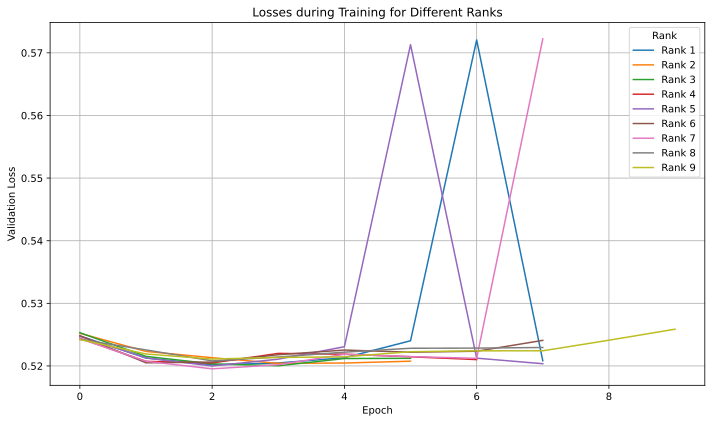

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Построение графика
plt.figure(figsize=(10, 6))
for i, r in enumerate(r_list):
    plt.plot(dora_losses[i], label=f"Rank {r}")

plt.title("Losses during Training for Different Ranks")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend(title="Rank")
plt.grid(True)
plt.tight_layout()

output_path = "dora_losses_plot.svg"  # Или "test_accuracy_plot.png"
plt.savefig(output_path, format="svg")  # Укажите нужный формат (svg, png, pdf и т.д.)
plt.show()

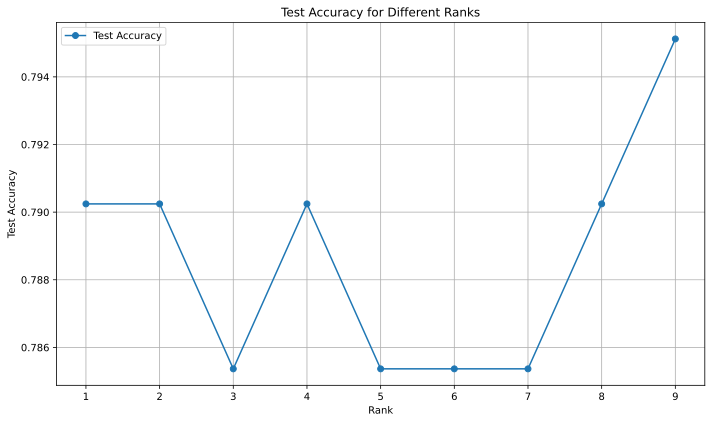

In [148]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(r_list, lora_test_accs, marker='o', label="Test Accuracy")

plt.title("Test Accuracy for Different Ranks")
plt.xlabel("Rank")
plt.ylabel("Test Accuracy")
plt.xticks(r_list)  # Установить метки на оси X для каждого ранга
plt.grid(True)
plt.legend()
plt.tight_layout()

output_path = "lora_test_accuracy_plot.svg"  # Или "test_accuracy_plot.png"
plt.savefig(output_path, format="svg")  # Укажите нужный формат (svg, png, pdf и т.д.)
plt.show()

In [115]:
exp.model = qlora_model.to('cuda')
exp.test(setting, 0)

205
shapes: torch.Size([16, 405, 61]) torch.Size([16, 405])
shapes: torch.Size([16, 405, 61]) torch.Size([16, 405])
shapes: torch.Size([16, 405, 61]) torch.Size([16, 405])
shapes: torch.Size([16, 405, 61]) torch.Size([16, 405])
shapes: torch.Size([16, 405, 61]) torch.Size([16, 405])
shapes: torch.Size([16, 405, 61]) torch.Size([16, 405])
shapes: torch.Size([16, 405, 61]) torch.Size([16, 405])
shapes: torch.Size([16, 405, 61]) torch.Size([16, 405])
shapes: torch.Size([16, 405, 61]) torch.Size([16, 405])
shapes: torch.Size([16, 405, 61]) torch.Size([16, 405])
shapes: torch.Size([16, 405, 61]) torch.Size([16, 405])
shapes: torch.Size([16, 405, 61]) torch.Size([16, 405])
shapes: torch.Size([13, 405, 61]) torch.Size([13, 405])
test shape: torch.Size([205, 2]) torch.Size([205, 1])
accuracy:0.7902439024390244


* accuracy-4bit: 0.7951219512195122
* accuracy-8bit: 0.8048780487804879
* accuracy: 0.8097560975609757